In [1]:
import pandas as pd

In [2]:
#Data Handling
from mlxtend.frequent_patterns import apriori,association_rules

In [3]:
#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [4]:
#Warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
!pip install openpyxl


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
path="Assignment-1_Data.xlsx"
df_original=pd.read_excel(path)
df=df_original.copy()
df.head()

,BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
print("#" * 50)
print(" " * 15, "Dataset Information")
print("#" * 50)
print("The Dataset has {} columns and {} rows.".format(df.shape[1], df.shape[0]))
print("The DataFrame has {} duplicated values and {} missing values.".format(df.duplicated().sum(), df.isnull().sum().sum()))
print(df.info())

##################################################
                Dataset Information
##################################################
The Dataset has 7 columns and 522064 rows.
The DataFrame has 5286 duplicated values and 135496 missing values.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522064 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   BillNo      522064 non-null  object        
 1   Itemname    520609 non-null  object        
 2   Quantity    522064 non-null  int64         
 3   Date        522064 non-null  datetime64[ns]
 4   Price       522064 non-null  float64       
 5   CustomerID  388023 non-null  float64       
 6   Country     522064 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 27.9+ MB
None


In [7]:
df.drop_duplicates(inplace=True)

In [8]:
print("#" * 30)
print(" " * 5, "Null Distribution")
print("#" * 30)
null = df.isnull().sum().to_frame().rename(columns = {0:'count'})
null['%'] = (null['count'] / len(df)) * 100.
null = null.sort_values(by = '%', ascending = False)
null.style.background_gradient(cmap = 'PRGn')

##############################
      Null Distribution
##############################


,count,%
CustomerID,133967,25.923511
Itemname,1455,0.281552
BillNo,0,0.000000
Quantity,0,0.000000
Date,0,0.000000
Price,0,0.000000
Country,0,0.000000


In [9]:
df.dropna(subset=['CustomerID', 'Itemname'], inplace=True)

In [10]:
df = df.rename(columns={'Itemname': 'ItemName'})
df['ItemName'] = df['ItemName'].str.lower()
df['CustomerID'] = df['CustomerID'].astype('int')

In [11]:
transactions_original = df.groupby(['BillNo', 'Date'])['ItemName'].apply(lambda x: ', '.join(x)).reset_index()

transactions_original.drop(columns=['BillNo', 'Date'], inplace=True)

transactions_original.head()

,ItemName
0,"white hanging heart t-light holder, white meta..."
1,"hand warmer union jack, hand warmer red polka dot"
2,"assorted colour bird ornament, poppy's playhou..."
3,"jam making set with jars, red coat rack paris ..."
4,bath building block word


In [12]:
transactions=transactions_original.copy()
transactions.head()

,ItemName
0,"white hanging heart t-light holder, white meta..."
1,"hand warmer union jack, hand warmer red polka dot"
2,"assorted colour bird ornament, poppy's playhou..."
3,"jam making set with jars, red coat rack paris ..."
4,bath building block word


In [13]:
def transform_and_validate_transactions(transactions_df, original_df):
    
    # Split 'ItemName' into individual items
    items_df = transactions_df['ItemName'].str.split(', ', expand=True)
    
    # Calculate the number of unique ['BillNo', 'Date'] combinations in original_df
    unique_transactions_count = original_df.drop_duplicates(subset=['BillNo', 'Date']).shape[0]
    # Validate the number of rows
    assert items_df.shape[0] == unique_transactions_count, \
        f"Row count mismatch! Expected: {unique_transactions_count}, Got: {items_df.shape[0]}"
    
    # Calculate the number of unique items across all transactions
    all_items = set()
    original_df['ItemName'].str.split(', ').apply(lambda items: all_items.update(items if items else []))
    max_product_counts = transactions['ItemName'].str.split(', ').apply(len).max()
    # Validate the number of columns
    assert items_df.shape[1] == max_product_counts, \
        f"Column count mismatch! Expected: {max_product_counts}, Got: {items_df.shape[1]}"
    
    # Return the transformed and validated DataFrame
    return items_df

# Apply the function and validate the results
transformed_and_validated_transactions = transform_and_validate_transactions(transactions_original, df)
print(transformed_and_validated_transactions.head())

                                  0                            1    \
0  white hanging heart t-light holder          white metal lantern   
1              hand warmer union jack    hand warmer red polka dot   
2       assorted colour bird ornament    poppy's playhouse bedroom   
3            jam making set with jars  red coat rack paris fashion   
4            bath building block word                         None   

                              2                                    3    \
0  cream cupid hearts coat hanger  knitted union flag hot water bottle   
1                            None                                 None   
2       poppy's playhouse kitchen    feltcraft princess charlotte doll   
3  yellow coat rack paris fashion         blue coat rack paris fashion   
4                            None                                 None   

                              4                                   5    \
0  red woolly hottie white heart.        set 7 babushka nesti

In [14]:
# Convert items to boolean columns
df_encoded = pd.get_dummies(transformed_and_validated_transactions, prefix='', prefix_sep='').groupby(level=0, axis=1).max()

In [15]:
from mlxtend.frequent_patterns import apriori, association_rules

def mine_association_rules(transactions_df, min_support=0.01, min_confidence=0.5):
    """
    This function encodes the transactions into boolean values, performs association rule mining,
    and returns the resulting rules.
    
    :param transactions_df: DataFrame with transactions where each item is represented in its own column.
    :param min_support: The minimum support for an itemset to be considered frequent.
    :param min_confidence: The minimum confidence for a rule to be considered.
    :return: DataFrame containing the association rules.
    """
    # Convert items to boolean columns
    df_encoded = pd.get_dummies(transactions_df, prefix='', prefix_sep='').groupby(level=0, axis=1).max()
    
    # Perform association rule mining
    frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
    
    return rules

# Now, use the function and display the association rules
rules = mine_association_rules(transformed_and_validated_transactions)
print("Association Rules:")
print(rules.head())

Association Rules:
                         antecedents                        consequents  \
0  (60 cake cases dolly girl design)  (pack of 72 retrospot cake cases)   
1      (60 teatime fairy cake cases)  (pack of 72 retrospot cake cases)   
2   (alarm clock bakelike chocolate)       (alarm clock bakelike green)   
3   (alarm clock bakelike chocolate)         (alarm clock bakelike red)   
4       (alarm clock bakelike ivory)       (alarm clock bakelike green)   

   antecedent support  consequent support   support  confidence       lift  \
0            0.018525            0.054529  0.010059    0.543027   9.958409   
1            0.034631            0.054529  0.017315    0.500000   9.169355   
2            0.017150            0.042931  0.011379    0.663462  15.454151   
3            0.017150            0.046999  0.011983    0.698718  14.866757   
4            0.025341            0.042931  0.014952    0.590022  13.743501   

   representativity  leverage  conviction  zhangs_metric   ja

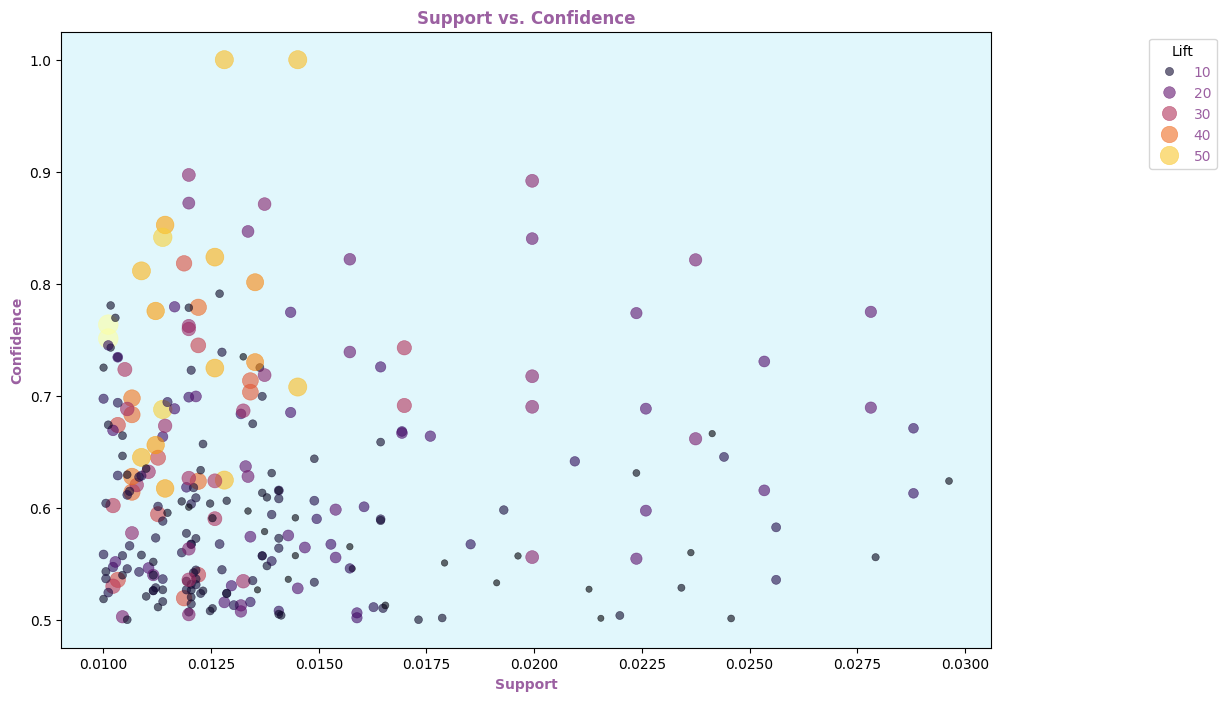

In [16]:
plt.figure(figsize=(12, 8))

# Set the background color
plt.axes().set_facecolor('#e1f7fc')  

# Plot scatterplot for Support vs. Confidence
sns.scatterplot(
    x="support",
    y="confidence",
    size="lift",
    data=rules,
    hue="lift",
    palette="inferno", # Color palette
    sizes=(20, 200),
    alpha=0.6,  # Transparency
    edgecolor=None  # Remove edge color for smoother appearance
)

# Customize the plot
plt.title('Support vs. Confidence', color='#9B60A1', fontweight='bold')  # #9B60A1 is purple
plt.xlabel('Support', color='#9B60A1', fontweight='bold')  
plt.ylabel('Confidence', color='#9B60A1', fontweight='bold')  
legend = plt.legend(title='Lift', loc='upper right', bbox_to_anchor=(1.25, 1))
plt.setp(legend.get_texts(), color='#9B60A1')
plt.savefig("support_vs_confidence.png", dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

In [17]:
import streamlit as st

In [ ]:
rules.to_csv("associationRules.csv")